In [1]:
import numpy as np
from scipy.linalg import inv, eigvals, norm
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm

from utils import *
from models.tvgti_pc_nonsparse import TimeVaryingSEM as TimeVaryingSEM_PC_NONSPARSE
from models.tvgti_pc_pp_nonsparse import TimeVaryingSEM as TimeVaryingSEM_PC_PP_NONSPARSE

In [2]:
def generate_random_S(N, sparsity, max_weight):
    S = np.zeros((N, N))
    
    for i in range(N):
        for j in range(i + 1, N):
            if np.random.rand() < sparsity:
                # weight = np.random.uniform(-max_weight, max_weight)
                weight = np.random.uniform(0, max_weight)
                S[i, j] = weight
                S[j, i] = weight
    
    # Ensure spectral radius < 1
    spectral_radius = max(abs(eigvals(S)))
    if spectral_radius >= 1:
        S = S / (spectral_radius + 0.1)

    S = S / norm(S)
    
    return S

def modify_S(S, edge_indices, factor=2.0):
    S_modified = S.copy()
    for (i, j) in edge_indices:
        if i != j:
            S_modified[i, j] *= factor
            S_modified[j, i] *= factor
    return S_modified

def generate_stationary_X(N, T, sparsity, max_weight, std_e):
    S = generate_random_S(N, sparsity=sparsity, max_weight=max_weight)
    S_series = [S for _ in range(T)]
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    I = np.eye(N)
    try:
        inv_I_S = inv(I - S)
    except np.linalg.LinAlgError:
        raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    X = inv_I_S @ e_t_series

    return S_series, X, e_t_series

def generate_stationary_X_from_S(S, N, T, std_e):
    S = S
    S_series = [S for _ in range(T)]
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    I = np.eye(N)
    try:
        inv_I_S = inv(I - S)
    except np.linalg.LinAlgError:
        raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    X = inv_I_S @ e_t_series

    return S_series, X

def generate_piecewise_X(N, T, sparsity, max_weight, std_e):
    max_weight_0 = max_weight
    max_weight_1 = max_weight
    S0 = generate_random_S(N, sparsity=sparsity, max_weight=max_weight_0)
    # S1 = generate_random_S(N, sparsity=sparsity, max_weight=max_weight_1)
    S1 = S0*2
    S_series = [S0 for _ in range(T // 2)] + [S1 for _ in range(T - T // 2)]
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    I = np.eye(N)
    try:
        inv_I_S0 = inv(I - S0)
        inv_I_S1 = inv(I - S1)
    except np.linalg.LinAlgError:
        raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    X0 = inv_I_S0 @ e_t_series[:, :T // 2]
    X1 = inv_I_S1 @ e_t_series[:, T // 2:]
    X = np.concatenate([X0, X1], axis=1)

    return S_series, X

def generate_piecewise_X_K(N, T, sparsity, max_weight, std_e, K):
    """
    Generates a time series X where the structural matrix S changes K times over T periods.
    
    Parameters:
    - N: int, the dimension of the square matrices.
    - T: int, total number of time periods.
    - sparsity: float, the proportion of zero elements in S.
    - max_weight: float, maximum absolute value for the weights in S.
    - std_e: float, standard deviation of the error terms.
    - K: int, number of times the structural matrix S changes.
    
    Returns:
    - S_series: list of numpy.ndarray, the sequence of S matrices used over time.
    - X: numpy.ndarray, the generated time series data.
    """
    S_list = []
    inv_I_S_list = []
    I = np.eye(N)

    for i in range(K):
        S = generate_random_S(N, sparsity=sparsity, max_weight=max_weight)
        S_list.append(S)
        try:
            inv_I_S = inv(I - S)
            inv_I_S_list.append(inv_I_S)
        except np.linalg.LinAlgError:
            raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    # Divide T into K segments
    segment_lengths = [T // K] * K
    segment_lengths[i-1] += T % K

    # Create S_series
    S_series = []
    for i, length in enumerate(segment_lengths):
        S_series.extend([S_list[i]] * length)

    # Generate error terms
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    # Compute X
    X_list = []
    start = 0
    for i, length in enumerate(segment_lengths):
        end = start + length
        X_i = inv_I_S_list[i] @ e_t_series[:, start:end]
        X_list.append(X_i)
        start = end

    X = np.concatenate(X_list, axis=1)

    return S_series, X


def solve_offline_sem(X_up_to_t, lambda_reg):
    N, t = X_up_to_t.shape
    S = cp.Variable((N, N), symmetric=True)
    
    # objective = (1/(2*t)) * cp.norm(X_up_to_t - S @ X_up_to_t, 'fro') + lambda_reg * cp.norm1(S)
    objective = (1/(2*t)) * cp.norm(X_up_to_t - S @ X_up_to_t, 'fro')
    
    constraints = [cp.diag(S) == 0]
    
    prob = cp.Problem(cp.Minimize(objective), constraints)
    
    prob.solve(solver=cp.SCS, verbose=False)
    
    if prob.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError("CVXPY did not find an optimal solution.")
    
    S_opt = S.value
    return S_opt

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


100%|██████████| 10000/10000 [00:00<00:00, 11520.71it/s]


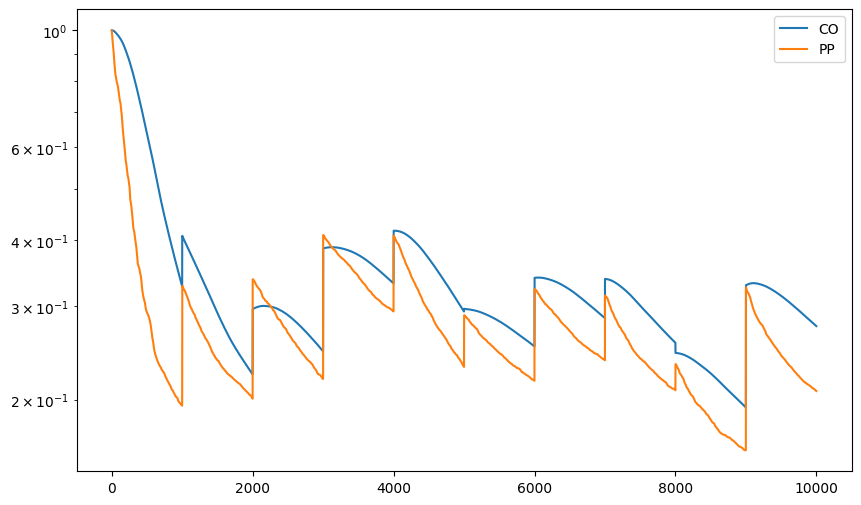

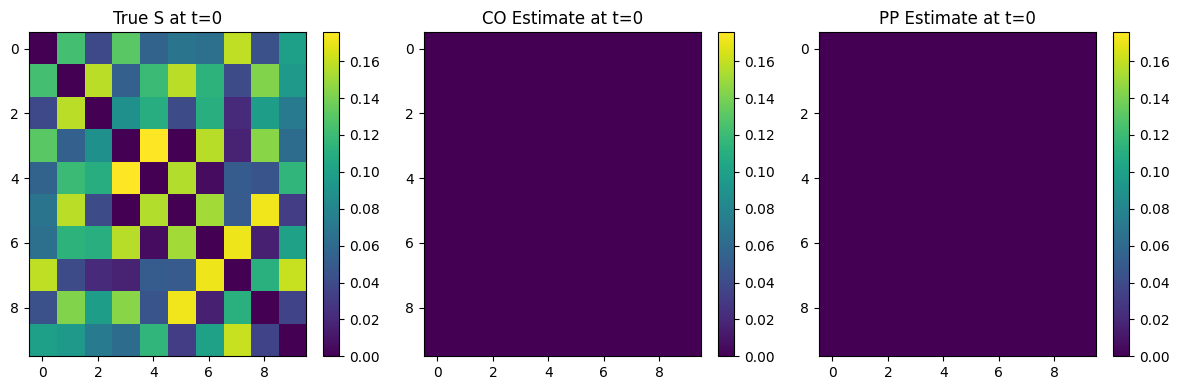

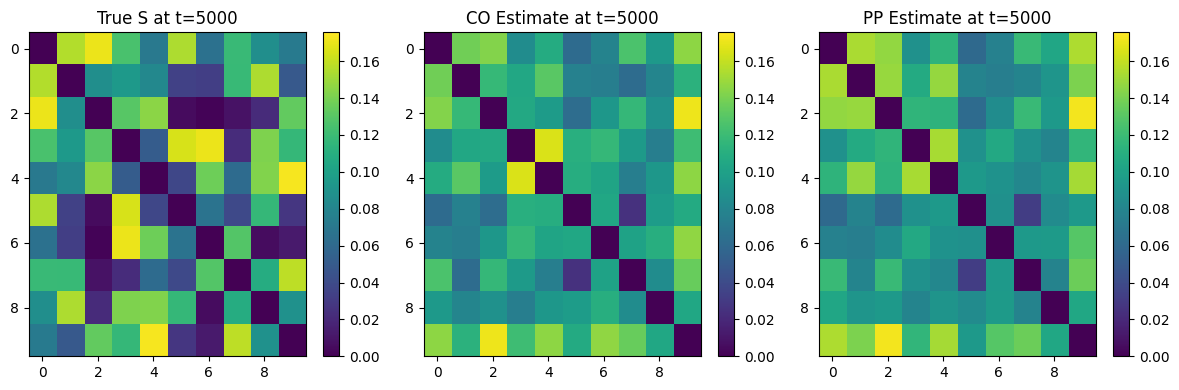

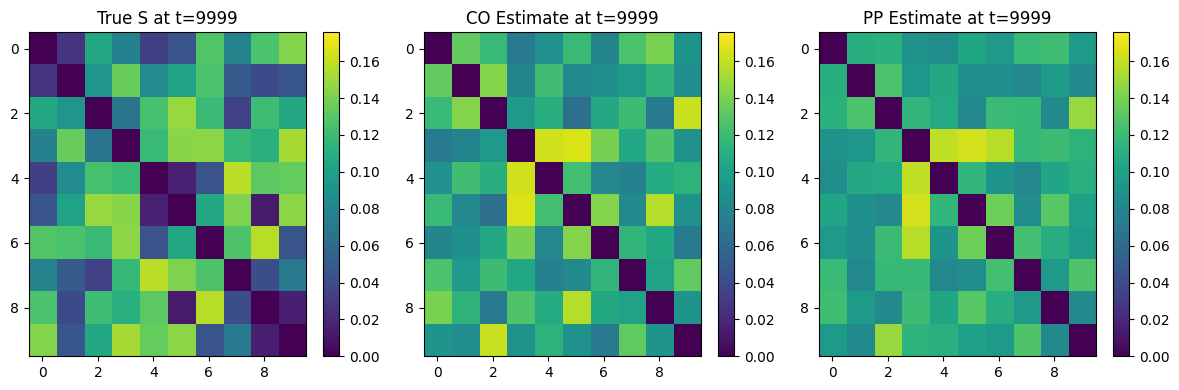

In [3]:
N = 10
T = 10000
sparsity = 100
max_weight = 0.5
variance_e = 0.05
std_e = np.sqrt(variance_e)
K = 10
window_size = 10

seed = 24
np.random.seed(seed)

# TV-SEMシミュレーション
# S_series, X, e_t_series = generate_stationary_X(N=N, T=T, sparsity=sparsity, max_weight=max_weight, std_e=std_e)

# S_series, X = generate_piecewise_X(N=N, T=T, sparsity=sparsity, max_weight=max_weight,
#                                     std_e=std_e, seed=seed)

S_series, X = generate_piecewise_X_K(N=N, T=T, sparsity=sparsity, max_weight=max_weight, std_e=std_e, K=K)

# オンラインTV-SEMパラメータ
P = 0
C = 1
lambda_reg = 0
# gamma = 0.999
gamma = 0.999
alpha = 0.0
# beta = 1e-7
beta_pc = 1e-3
beta_pp = 1e-4

# S_0 = S_series[512]
# S_0 = np.random.rand(N, N)
S_0 = np.zeros((N, N))

tv_sem_pc = TimeVaryingSEM_PC_NONSPARSE(N, S_0, lambda_reg, alpha, beta_pc, gamma, P, C)
tv_sem_pp = TimeVaryingSEM_PC_PP_NONSPARSE(N, S_0, lambda_reg, alpha, beta_pp, gamma, P, C, window_size)
estimates_pc, cost_values_pc = tv_sem_pc.run(X)
estimates_pp = tv_sem_pp.run(X)

S_opts = []
NSE_pc = []
NSE_pp = []
# error_opt = []
error_pc = []
error_pp = []
cost_pc = []
cost_pp = []

# for i in tqdm(range(T)):
#     S_opt = solve_offline_sem(X[:, (i//(T//K))*(T//K):i+1], lambda_reg)
#     S_opts.append(norm(S_opt))

for i, estimate in enumerate(estimates_pc):
    # NSE_pc.append(norm(estimate - S_opt) / norm(S_opt))
    error_pc.append(norm(estimate - S_series[i]) ** 2 / (norm(S_series[i]) ** 2))
    cost_pc.append(norm(X[:, i] - estimate @ X[:, i]) ** 2)

for i, estimate in enumerate(estimates_pp):
    # NSE_pp.append(norm(estimate - S_opt) / norm(S_opt))
    error_pp.append(norm(estimate - S_series[i]) ** 2 / (norm(S_series[i]) ** 2))
    cost_pp.append(norm(X[:, i] - estimate @ X[:, i]) ** 2)



plt.figure(figsize=(10,6))
# plt.plot(error_opt, label='OPT')
plt.plot(error_pc, label='CO')
plt.plot(error_pp, label='PP')
# plt.plot(NSE_pc, label='CO')
# plt.plot(NSE_pp, label='PP')
# plt.xlabel('Time Step')
# plt.ylabel('Error')
# plt.yscale('log')

# plt.plot(cost_pc, label='CO')
# plt.xlabel('Time Step')
# plt.ylabel('Cost function')
plt.yscale('log')

# plt.plot(cost_values_pc, label='CO')
# plt.plot(cost_pp, label='PP')

plt.legend()
plt.show()

# プロットしたい時間点を指定
time_points = [0, T//2, T-1]  # 開始時、中間時、終了時

data_min = np.inf
data_max = -np.inf

for t in time_points:
    data_min = min(data_min, S_series[t].min(), estimates_pc[t].min(), estimates_pp[t].min())
    data_max = max(data_max, S_series[t].max(), estimates_pc[t].max(), estimates_pp[t].max())

# プロット部分
for t in time_points:
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,3,1)
    plt.imshow(S_series[t], cmap='viridis', aspect='auto', vmin=data_min, vmax=data_max)
    plt.colorbar()
    plt.title(f'True S at t={t}')
    
    plt.subplot(1,3,2)
    plt.imshow(estimates_pc[t], cmap='viridis', aspect='auto', vmin=data_min, vmax=data_max)
    plt.colorbar()
    plt.title(f'CO Estimate at t={t}')
    
    plt.subplot(1,3,3)
    plt.imshow(estimates_pp[t], cmap='viridis', aspect='auto', vmin=data_min, vmax=data_max)
    plt.colorbar()
    plt.title(f'PP Estimate at t={t}')
    
    plt.tight_layout()
    plt.show()